# Mike's cosine test case, multichannel

The goal of this example is separating the signal from the random fields, themselves.

Begin by making the same data file.

In [1]:
import numpy as np
import pyEXP

f = open('Test.dat','w')
omega = 0.75
for i in range(0,10000):
    T = 0.01*i
    phi = omega*T
    R = np.random.rand(3) + np.cos(phi)
    print(T, R[0], R[1], R[2], file=f)

f.close()

We can then use the `factory` method to generate coefficients. Each coefficient type has its own class
particular to its geometry: spherical, cylindrical, or table data for example.  The `factory` method 
attempts to deduce the coefficient type and build an instance of the appropriate coefficient class:

In [2]:
coefs = pyEXP.coefs.Coefs.factory('Test.dat')

---- Coefs::factory: error opening as HDF5, trying EXP native and ascii table
---- Coefs::factory: read ascii and created TableData


The output messages tells the story.  The `factory` attempted to open the input file as an HDF5 
coefficient file.  Each HDF5 coeffient class identifies its creator.  When that failed, the `factory` 
opened the data as an ascii data table successfully.

Alternatively, we can load a coefficient object for table data from Numpy arrays directly.  First, 
remake the data:

In [3]:
times = [] # This holds the array of time
data  = [] # This holds rows of data for each time
for i in range(0,10000):
    T = 0.01*i
    phi = omega*T
    R = np.random.rand(3) + np.cos(phi)
    times.append(T)
    data.append(R)

Then, we can make a coefficient object with the class contructor instead of the `factory`:

In [4]:
# coefs = pyEXP.coefs.TableData(times, data)

### Now generate the SSA

This time, we'll include all three channels, which have the same signal but independent randoom components.

In [5]:
# A list with three keys.  Keys are integer arrays (or lists).  
# The first column of the data table has the key [0], etc.
keylst = [[0], [1], [2]]
config = {"cosine": (coefs, keylst, [])}

# Window size is half the time series (a good default choice if it's practical)
window = int(len(coefs.Times())/2)

# Only compute the first 10 PCs
npc = 10

# An an example of making YAML config flags (commented out here)
flags = """
# Jacobi: true
Traj: true
"""

# Initialize the MSSA and compute the eigenvalues
ssa = pyEXP.mssa.expMSSA(config, window, npc, flags)
ev = ssa.eigenvalues()

---- Eigen is using 1 threads
shape U = 15000 x 10


### Plot the eigenvalues

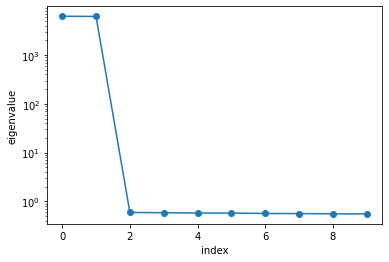

In [6]:
import matplotlib.pyplot as plt

plt.semilogy(ev, '-o')
plt.xlabel('index')
plt.ylabel('eigenvalue')
plt.show()

The cosine fields give a pair of primary PCs. The noise is spread into the remaining PCs. I'm not sure why the last ev is so tiny.  I think it's likely to be RedSVD since that behavior is time-series rank dependent.

### Look at the first 10 PCs

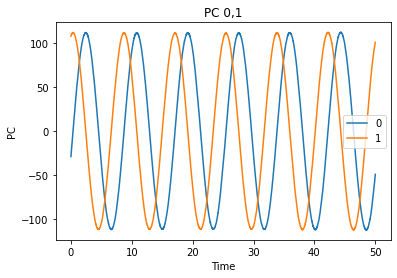

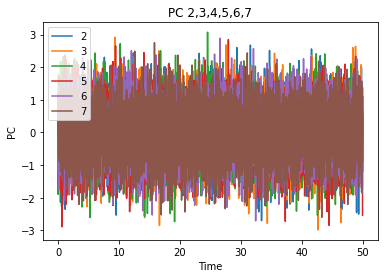

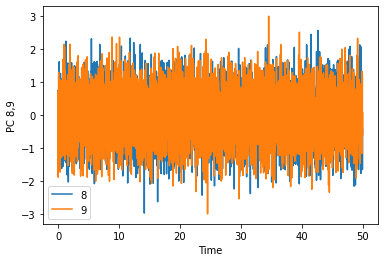

In [7]:
pc = ssa.getPC()
nt = pc.shape[0]
for i in range(0,2):
    plt.plot(coefs.Times()[:nt], pc[:,i], label=str(i))
plt.xlabel('Time')
plt.ylabel('PC')
plt.legend()
plt.title("PC 0,1")
plt.show()

for i in range(2,8):
    plt.plot(coefs.Times()[:nt], pc[:,i], label=str(i))
plt.xlabel('Time')
plt.ylabel('PC')
plt.legend()
plt.title('PC 2,3,4,5,6,7')
plt.show()

for i in range(8,10):
    plt.plot(coefs.Times()[:nt], pc[:,i], label=str(i))
plt.xlabel('Time')
plt.ylabel('PC 8,9')
plt.legend()
plt.show()


The first two PCs contain the sinusoidal variation.  The remaining PCs represent the noise.  Not sure what's up with the last ev...

### Compute the power spectrum of the PCs

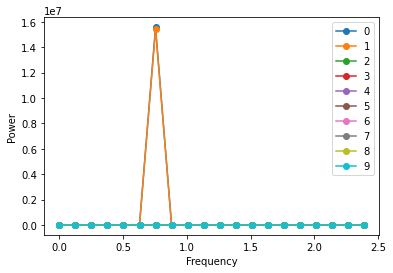

In [8]:
freq, power = ssa.pcDFT()
for i in range(power.shape[1]):
    plt.plot(freq[0:20], power[0:20,i], '-o', label=str(i))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend()
plt.show()

We expect our power at $f=1$ and that's what we find!

### Compute the power spectrum of the reconstruction

In [9]:
ssa.reconstruct([0, 1])

# Show the keys as a demonstration
ssa.getRCkeys()

[[0, 0], [1, 0], [2, 0]]

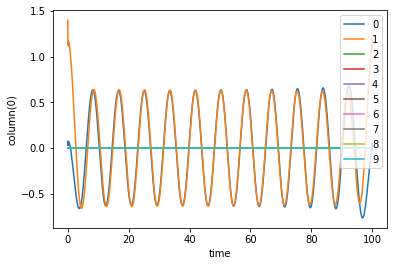

In [10]:
recon = ssa.getRC([0, 0])
for i in range(recon.shape[1]):
    plt.plot(coefs.Times(), recon[:,i], label=str(i))
plt.xlabel('time')
plt.ylabel('column(0)')
plt.legend()
plt.show()

In [11]:
ssa.reconstruct([*range(10)])

Redo the reconstructions for all 10 PCs.  The look at the reconstruction for the first data column.

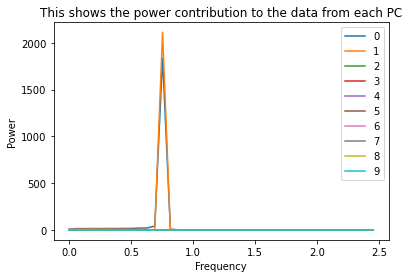

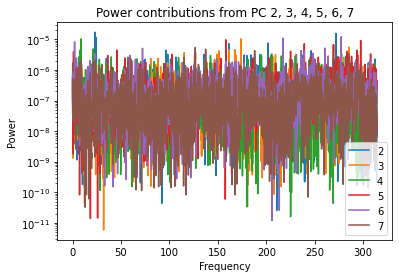

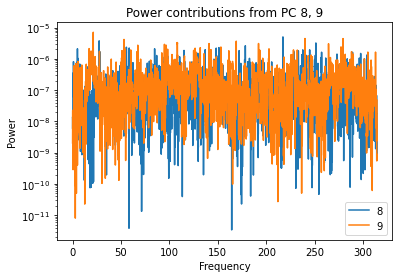

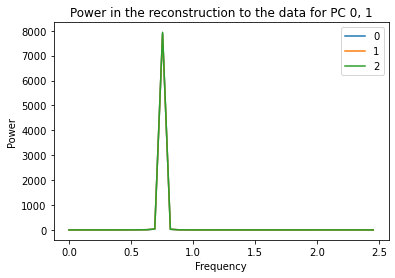

In [12]:
key = [0, 0] # First column, first data set (there is only one data set here)

freq, power = ssa.singleDFT(key)

for i in range(power.shape[1]):
    plt.plot(freq[0:40], power[0:40,i], label=str(i))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('This shows the power contribution to the data from each PC')
plt.legend()
plt.show()

for i in range(2, 8):
    plt.semilogy(freq, power[:,i], label=str(i))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Power contributions from PC 2, 3, 4, 5, 6, 7')
plt.legend()
plt.show()

for i in range(8, 10):
    plt.semilogy(freq, power[:,i], label=str(i))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Power contributions from PC 8, 9')
plt.legend()
plt.show()

freq, power = ssa.channelDFT()
for i in range(power.shape[1]):
    plt.plot(freq[0:40], power[0:40,i], label=str(i))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Power in the reconstruction to the data for PC 0, 1')
plt.legend()
plt.show()

This shows the power contribution to the data column 0 from each PC.  It's all PC 0, 1, of course, at the same frequency ($f=1$) as the PC itself.   The remaining PCs contain the random fields; these have a flat power spectrum expected for pure white noise.